## Tensorflow basics- Regression

In [3]:
import tensorflow as tf

In [4]:
hello = tf.constant('hello')

In [7]:
with tf.Session() as sess:
    print(hello)

Tensor("Const:0", shape=(), dtype=string)


In [8]:
sess = tf.Session()

In [9]:
sess.run(hello)

b'hello'

In [12]:
x = tf.constant(8)
sess.run(x)
print(type(sess.run(x)))

<class 'numpy.int32'>


In [13]:
# Operations

In [14]:
x = tf.constant(2)
y = tf.constant(3)

In [16]:
with tf.Session() as sess:
    print('Operations with Constants')
    print('Addition: ', sess.run(x+y))
    print('Subtraction: ', sess.run(x-y))
    print('Multiplication: ', sess.run(x*y))
    print('Division: ', sess.run(x/y))

Operations with Constants
Addition:  5
Subtraction:  -1
Multiplication:  6
Division:  0.6666666666666666


In [17]:
# placeholder
x = tf.placeholder(tf.int32)

In [18]:
x

<tf.Tensor 'Placeholder:0' shape=<unknown> dtype=int32>

In [19]:
y = tf.placeholder(tf.int32)

In [20]:
add = tf.add(x,y)

In [23]:
sub = tf.subtract(x,y)

In [25]:
mul = tf.multiply(x,y)

In [27]:
d = {x:20, y:30}

In [30]:
with tf.Session() as sess:
    print('Operations with Placeholders')
    print('addition', sess.run(add, feed_dict={x:20, y:30}))
    print('subtraction', sess.run(sub, feed_dict=d))
    print('Multiplication', sess.run(mul, feed_dict=d))

Operations with Placeholders
addition 50
subtraction -10
Multiplication 600


In [31]:
import numpy as np

In [32]:
a = np.array([[5.0, 5.0]])
b = np.array([[5.0], [5.0]])

In [33]:
a

array([[5., 5.]])

In [34]:
b

array([[5.],
       [5.]])

In [35]:
a.shape

(1, 2)

In [36]:
b.shape

(2, 1)

In [37]:
mat1 = tf.constant(a)

In [38]:
mat2 = tf.constant(b)

In [39]:
matrix_multi = tf.matmul(mat1, mat2)

In [40]:
with tf.Session() as sess:
    results = sess.run(matrix_multi)
    print(results)

[[50.]]


### Tensorflow Regression

In [3]:
#from _future_ import absolute_import, division, print_function
import pathlib

In [5]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.version)

<module 'tensorflow._api.v1.version' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\tensorflow_core\\_api\\v1\\version\\__init__.py'>


#### Import the dataset

In [10]:
dataset_path = r'C:\Users\Administrator\Downloads\auto-mpg.data'

In [11]:
column_names= ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 
              'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                         na_values = "?", comment='\t',
                         sep=" ", skipinitialspace=True)

In [12]:
dataset = raw_dataset.copy()

In [13]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### Clean the data

In [14]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [16]:
# drop the rows with na values
dataset = dataset.dropna()

In [18]:
# The 'origin column' is not really a numeric, it's categorical.
# so convert that to a one-hot:

In [19]:
origin = dataset.pop("Origin")

In [21]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [ ]:
# this code works the same way as the previous cell
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

#### Split data into train and test

In [25]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

##### Inspect the data

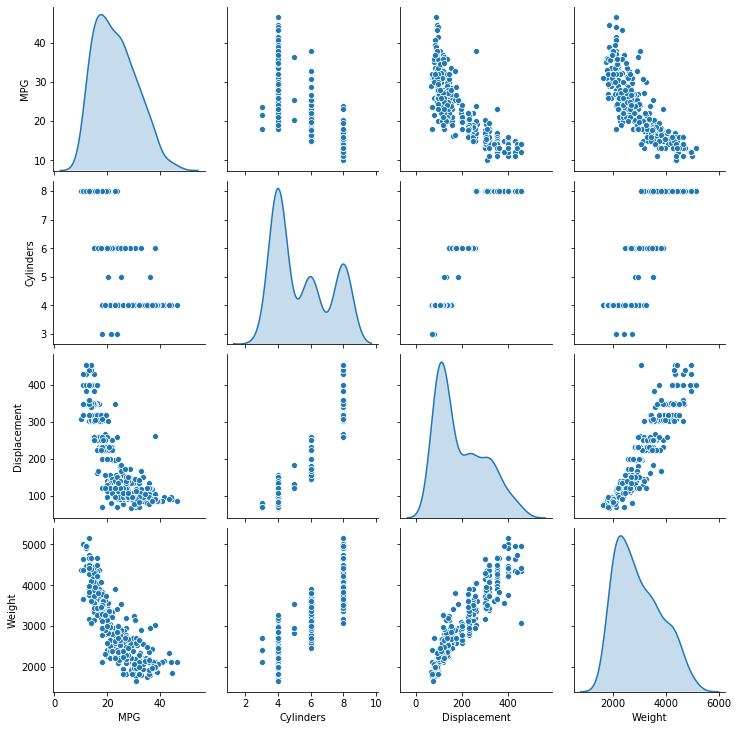

In [27]:
# Have a quick look at the joint distribution of a few pairs from the training set

sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [28]:
# Also look at the overall statistics:

train_stats = train_dataset.describe()
train_stats.pop('MPG')

count    314.000000
mean      23.310510
std        7.728652
min       10.000000
25%       17.000000
50%       22.000000
75%       28.950000
max       46.600000
Name: MPG, dtype: float64

In [31]:
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### Split features from labels

In [33]:
#Separate the target value, or "label", from the features. 
#This label is the value that you will train the model to predict.

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

##### Normalize the data

In [34]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

### The model
#### Build the model

In [37]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [38]:
model = build_model()

##### Inspect the model

In [40]:
# Use the .summary method to print a simple description of the model

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [42]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result
# the array should display 10 values representing the MPG predictions

array([[-0.44334614],
       [-0.3555354 ],
       [-0.60154486],
       [-0.404228  ],
       [-0.68547857],
       [-0.25494277],
       [-0.8186916 ],
       [-0.5829222 ],
       [-0.23294163],
       [-0.78386736]], dtype=float32)

#### Train the model

In [43]:
# Display training progress by printing a single dot for each completed epoch

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')


EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [44]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.538680,0.991109,2.538681,10.709591,2.457196,10.709591,995
996,2.535744,1.021514,2.535744,10.060017,2.358506,10.060017,996
997,2.338763,0.951422,2.338763,10.491804,2.401530,10.491804,997
998,2.320436,0.955800,2.320436,9.549743,2.311839,9.549743,998
999,2.462058,0.997581,2.462058,10.679233,2.418822,10.679234,999


In [45]:
import matplotlib.pyplot as plt

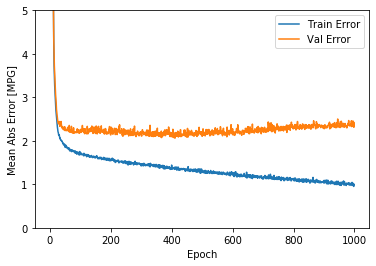

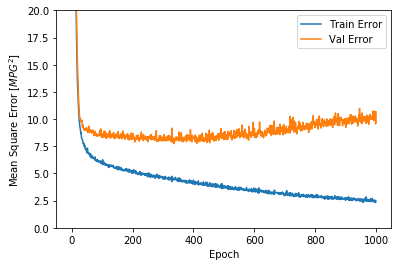

In [47]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
            label= 'Val Error')
    plt.legend()
    plt.ylim([0, 5])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
            label= 'Val Error')
    plt.legend()
    plt.ylim([0, 20])
    
plot_history(history)

#### Dealing with overfitting

###### Early stopping


........................................................................

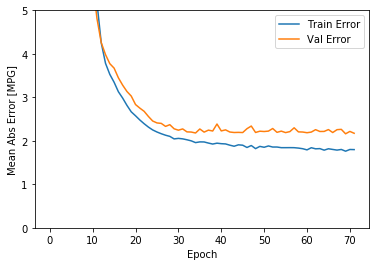

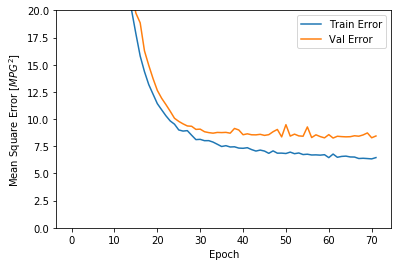

In [49]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [50]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.1165 - mean_absolute_error: 1.9865 - mean_squared_error: 6.1165
Testing set Mean Abs Error:  1.99 MPG


#### Make predictions

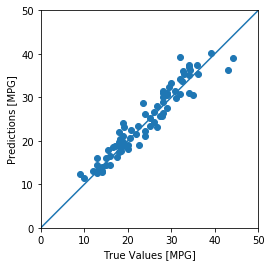

In [51]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


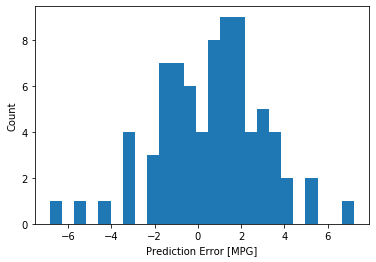

In [52]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")